# Условие задачи
Используя схему бегущего счета и итерационные методы, решить задачу для квазилинейного уравнением переноса:
$$
\begin{equation*}
 \begin{cases}
   \frac{\partial u}{\partial t} - u \frac{\partial u}{\partial x} = 0, -1 \leqslant x < 0
   \\
   u(x, 0) = \phi(x)
   \\
   u(0, t) = \mu(t)
 \end{cases}
\end{equation*}
$$
где:

$$
\phi(x) = 2 - \frac{4}{\pi}arctg(x + 2)
$$

$$
\mu(t) = (2 - \frac{4}{\pi}arctg2)e^{-t}
$$

Находим характеристики:

$$
\frac{dt}{1}=\frac{dx}{-1}=\frac{du}{0}
$$

$$
\begin{equation*}
\begin{cases}
    u = u(x_0, t_0) = const
    \\
    t - t_0 = - \frac{1}{u}(x - x_0)
\end{cases}
\end{equation*}
$$

$$
t_0 = 0: t = - \frac{1}{\phi(x_0)}(x - x_0)
$$

$$
x_0 = 0: t = - \frac{x}{\mu(t_0)} + t_0
$$

Зададим параметры уравнения:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image

In [2]:
a = -1.  # левый конец области по x
b = 0.  # правый конец области по x
T = 1.  # расчетное время

m = 100  # число интервалов по x
n = 100  # число интервалов по t

tau = T / m  # шаг по времени
h = (b - a) / n  # шаг по x

Введем равномерную сетку по x и t:
    - число шагов - n и m соответственно
    - число узлов - n + 1 и m + 1 соответственно
Нумерацию узлов будем вести от 0 до n, m соответственно

In [3]:
t = np.linspace(0, T, m + 1)  # число шагов - m + 1
x = np.linspace(a, b, n + 1)  # число шагов - n + 1

Зададим функции начальных и граничных условий:

In [4]:
def phi(x):
    # x - NumPy array
    return 2 - 4 / np.pi * np.arctan(x + 2)


def mu(t):
    # t - NumPy array
    return (2 - 4 / np.pi * np.arctan(2)) * np.exp(-t)

Теперь можно построить два семейства характеристик:

In [5]:
def ch1(x, x0):
    # t0 = 0
    return -1 / phi(x0) * (x - x0)


def ch2(x, t0):
    # x0 = 0
    return -x / mu(t0) + t0

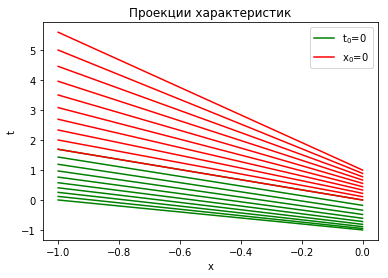

In [6]:
# по 5 линий каждого семейства
t0mesh = np.linspace(0, T, 10)
x0mesh = np.linspace(a, b, 10)

for x0 in x0mesh:
    line_t, = plt.plot(x, ch1(x, x0), "g-")
for t0 in t0mesh:
    line_x, = plt.plot(x, ch2(x, t0), "r-")
plt.title("Проекции характеристик")
plt.xlabel("x")
plt.ylabel("t")
plt.legend((line_t, line_x), ("t$_{0}$=0", "x$_{0}$=0"))

Характеристики не пересекаются, значит разрывов не будет. Этого следовало ожидать, ведь НУ и ГУ строго монотонны, согласованы и непрерывны.

# Численное решение
Приведем уравнение к дивергентному виду:
$$
\frac{\partial u}{\partial t} - \frac{\partial}{\partial x}(\frac{u^2}{2}) = 0, -1 \leqslant x < 0
$$

Будем использовать неявный трехточечный шаблон. Он безусловно устойчив для случая отрицательной скорости переноса. Аппроксимирует схему с первым порядком точности.

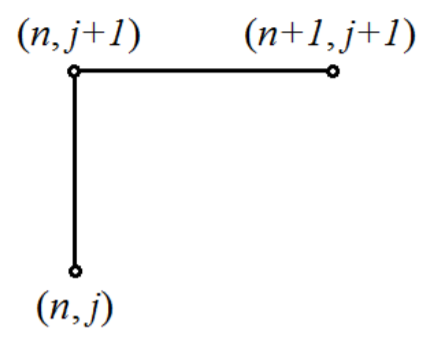

In [7]:
Image(filename='pattern.png')

Составим разностную аппроксимацию уравнения:

$$
\begin{equation*}
    \begin{cases}
        \frac{y_i^{j + 1} - y_i^j}{\tau} - \frac{({y_{i + 1}^{j + 1}})^2 - ({y_i^{j + 1}})^2}{h} = 0, 
        i = \overline{0, n - 1}, j = \overline{1, m}
        \\
        y_i^0 = \phi(x_i), i = \overline{0, n}
        \\
        y_n^j = \mu(t_j), j = \overline{0, m}
    \end{cases}
\end{equation*}
$$

В схеме бегущего счета будем двигаться от правого края к левому, тогда нам на каждом шаге будут известны $y_i^j$ и $y_{i + 1}^{j + 1}$. Неизвестным будет только $y_i^{j + 1}$. Мы будем находить его из нелинейного уравнения методом Ньютона.

In [8]:
def newton(f, Df, x0=0, epsilon=1e-6, max_iter=100):
    '''Approximate solution of f(x)=0 by Newton's method.

    Parameters
    ----------
    f: function
        Function for which we are searching for a solution f(x)=0.
    Df: function
        Derivative of f(x).
    x0: number
        Initial guess for a solution f(x)=0.
    epsilon: number
        Stopping criteria is abs(f(x)) < epsilon.
    max_iter: integer
        Maximum number of iterations of Newton's method.

    Returns
    -------
    xn: number
        Implement Newton's method: compute the linear approximation
        of f(x) at xn and find x intercept by the formula
            x = xn - f(xn) / Df(xn)
        Continue until abs(f(xn)) < epsilon and return xn.
        If Df(xn) == 0, return None. If the number of iterations
        exceeds max_iter, then return None.

    Examples
    --------
    >>> f = lambda x: x ** 2 - x - 1
    >>> Df = lambda x: 2 * x - 1
    >>> newton(f, Df, 1, 1e-8, 10)
    Found solution after 5 iterations.
    1.618033988749989
    '''
    xn = x0
    for n in range(0, max_iter):
        fxn = f(xn)
        if abs(fxn) < epsilon:
            return xn
        Dfxn = Df(xn)
        if Dfxn == 0:
            return None
        xn = xn - fxn / Dfxn
    return None

Зададим точность и максимальное число итераций в методе Ньютона

In [9]:
eps = 1e-6
max_it = 100

Создадим массив нулей размером (m + 1, n + 1), и заполним НУ и ГУ

In [10]:
y = np.zeros((m + 1, n + 1))
y[0, :] = phi(x)
y[:, -1] = mu(t)

In [11]:
for j in range(m):
    for i in range(n - 1, -1, -1):
        # f = 0 -> y_i^{j + 1}
        f = lambda x: (x - y[j, i]) / tau - (y[j + 1, i + 1] ** 2 - x ** 2) / h
        # берем правую производную, потому что значение справа всегда известно. Первый порядок точности нас устраивает
        Df = lambda x: (f(x + h) - f(x)) / h
        # находим y_i^{j + 1} методом Ньютона. В качестве начального приближения берем значение y в соседнем узле.
        y[j + 1, i] = newton(f, Df, y[j + 1, i + 1], eps, max_it)

Построим график полученного решения:

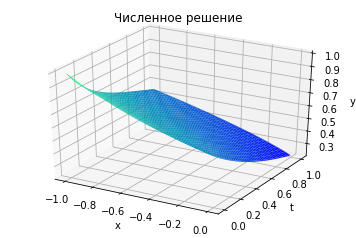

In [12]:
xmesh, tmesh = np.meshgrid(x, t)
ax = plt.figure().add_subplot(111, projection='3d')
ax.plot_surface(xmesh, tmesh, y, cmap='winter', edgecolor='None')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel("y")
ax.set_title("Численное решение")
plt.show()